Import the relevent libraries
Pandas package for loading and preprocessing the dataset

In [106]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

Read the training dateset

In [107]:
#ALso remember to parse the date column. This will be helpful in the next step
training_data=pd.read_csv('Arundo_take_home_challenge_training_set.csv',sep=',',parse_dates=['date'])
#Have a look at the data
training_data.head()

,date,calendar_code,request_count,site_count,max_temp,min_temp,precipitation,events
0,2014-09-01,0.0,165,6,30.6,22.8,0.0,Rain
1,2014-09-02,1.0,138,7,32.8,22.8,15.5,Rain-Thunderstorm
2,2014-09-03,1.0,127,7,29.4,18.3,0.0,None
3,2014-09-04,1.0,174,7,29.4,17.2,0.0,None
4,2014-09-05,1.0,196,7,30.6,21.7,0.0,Fog


Let us try to get a better insight into the data. First let us have a look at the dependence of request counts on the float variables.

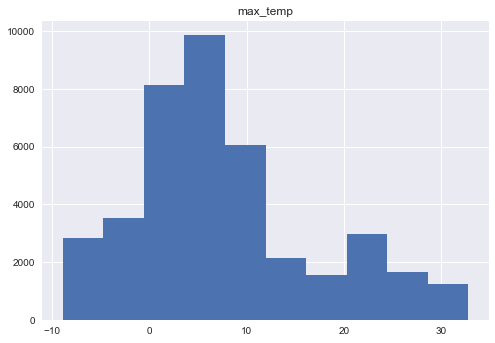

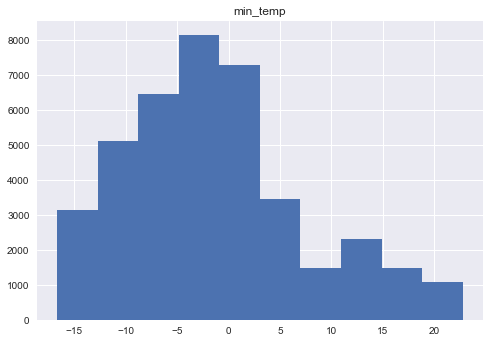

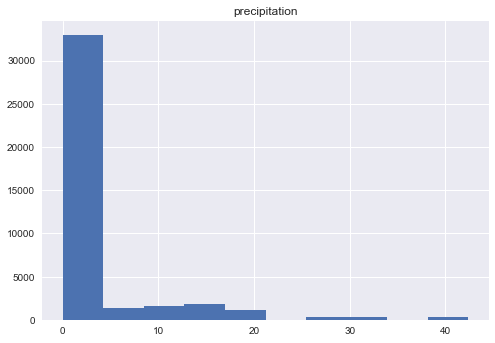

In [108]:
training_data.hist('max_temp',weights=training_data['request_count'])
training_data.hist('min_temp',weights=training_data['request_count'])
training_data.hist('precipitation',weights=training_data['request_count'])
plt.show()

From the above histograms we see that most of the request comes when 1). maximum temperature is below 10C 2). min temperature is below 2C 3) When there is zero precipitation 

We use violin plot for dependence on the categorical variables (https://blog.modeanalytics.com/violin-plot-examples/)

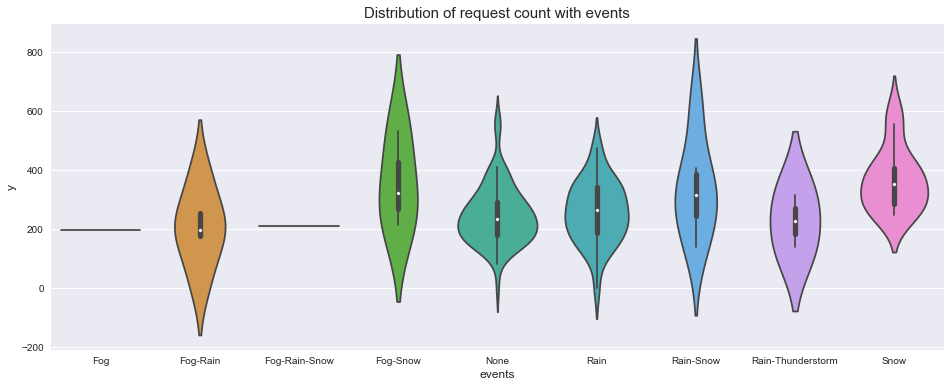

In [109]:
var_name = "events"
col_order = np.sort(training_data[var_name].unique()).tolist()
plt.figure(figsize=(16,6))
sns.violinplot(x=var_name, y='request_count', data=training_data, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of request count with "+var_name, fontsize=15)
plt.show()

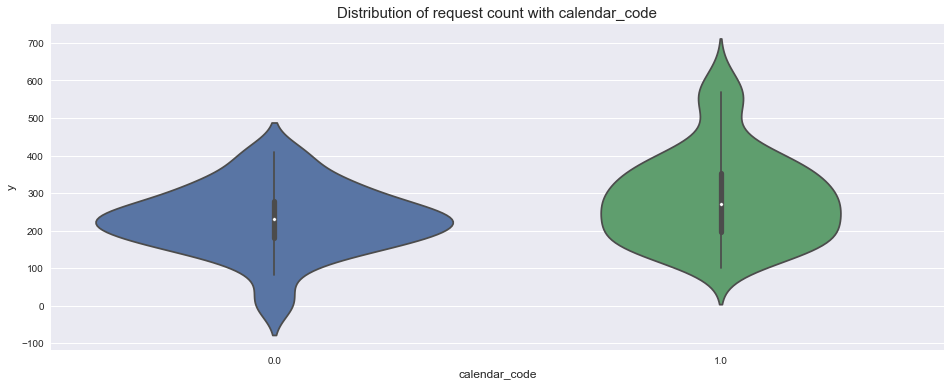

In [110]:
var_name = "calendar_code"
col_order = np.sort(training_data[var_name].unique()).tolist()
plt.figure(figsize=(16,6))
sns.violinplot(x=var_name, y='request_count', data=training_data, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of request count with "+var_name, fontsize=15)
plt.show()

The date as such is not as important. May be the site maintenence is dependant on the working day or weekend. We add an additional column with the week day (0: Monday, ... 6: Sunday)

In [111]:
training_data['day_of_week'] = training_data['date'].dt.dayofweek
training_data['week_day'] = training_data['date'].dt.weekday_name
training_data.head()

,date,calendar_code,request_count,site_count,max_temp,min_temp,precipitation,events,day_of_week,week_day
0,2014-09-01,0.0,165,6,30.6,22.8,0.0,Rain,0,Monday
1,2014-09-02,1.0,138,7,32.8,22.8,15.5,Rain-Thunderstorm,1,Tuesday
2,2014-09-03,1.0,127,7,29.4,18.3,0.0,None,2,Wednesday
3,2014-09-04,1.0,174,7,29.4,17.2,0.0,None,3,Thursday
4,2014-09-05,1.0,196,7,30.6,21.7,0.0,Fog,4,Friday


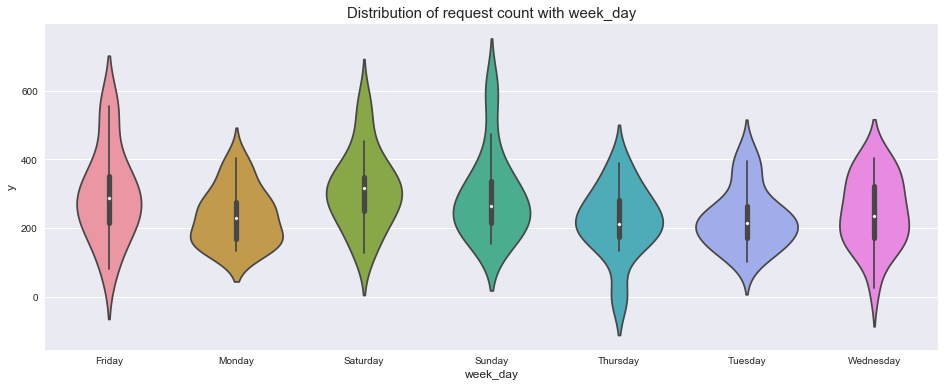

In [112]:
var_name = "week_day"
col_order = np.sort(training_data[var_name].unique()).tolist()
plt.figure(figsize=(16,6))
sns.violinplot(x=var_name, y='request_count', data=training_data, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of request count with "+var_name, fontsize=15)
plt.show()

Next we convert the events into some unique identifiers (integers). This will result in an additional column "events_code"

In [113]:
training_data['events_code'] = pd.Categorical(training_data["events"]).codes
training_data.head()

,date,calendar_code,request_count,site_count,max_temp,min_temp,precipitation,events,day_of_week,week_day,events_code
0,2014-09-01,0.0,165,6,30.6,22.8,0.0,Rain,0,Monday,5
1,2014-09-02,1.0,138,7,32.8,22.8,15.5,Rain-Thunderstorm,1,Tuesday,7
2,2014-09-03,1.0,127,7,29.4,18.3,0.0,None,2,Wednesday,4
3,2014-09-04,1.0,174,7,29.4,17.2,0.0,None,3,Thursday,4
4,2014-09-05,1.0,196,7,30.6,21.7,0.0,Fog,4,Friday,0


Since request count is the target variable, we store it separately as "y"

In [114]:
y=training_data["request_count"]
print("Shape of y ",y.shape)

Shape of y  (152,)


Drop the redundant columns now "date","events","request_count"

In [115]:
training_data = training_data.drop(["date","events","request_count","week_day"],axis=1)
training_data.head()

,calendar_code,site_count,max_temp,min_temp,precipitation,day_of_week,events_code
0,0.0,6,30.6,22.8,0.0,0,5
1,1.0,7,32.8,22.8,15.5,1,7
2,1.0,7,29.4,18.3,0.0,2,4
3,1.0,7,29.4,17.2,0.0,3,4
4,1.0,7,30.6,21.7,0.0,4,0


The categorical values day_of_week, events_code and calender code needs to be one-hot-encoded to be used as a feature input vector. 

In [116]:
training_data= pd.get_dummies(training_data,columns=["calendar_code","events_code","day_of_week"],prefix=["calendar","event","week"])
training_data.head()

,site_count,max_temp,min_temp,precipitation,calendar_0.0,calendar_1.0,event_0,event_1,event_2,event_3,...,event_6,event_7,event_8,week_0,week_1,week_2,week_3,week_4,week_5,week_6
0,6,30.6,22.8,0.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,7,32.8,22.8,15.5,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,7,29.4,18.3,0.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,7,29.4,17.2,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,7,30.6,21.7,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Call the feature vectors X

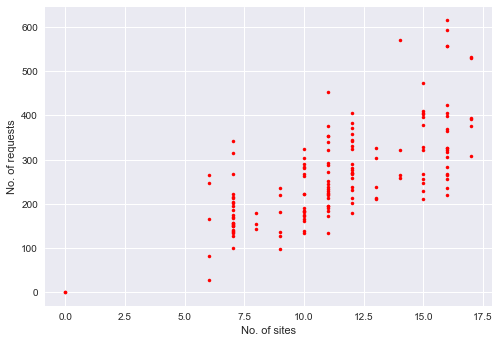

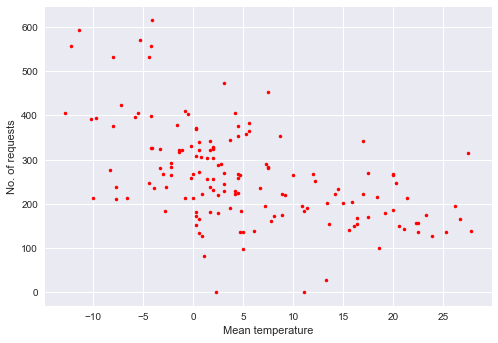

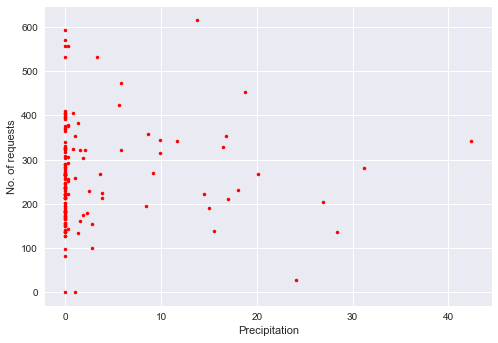

In [117]:
X=training_data.values

plt.figure(1)
plt.plot(X[:,0],y[:],'r.')
plt.xlabel("No. of sites")
plt.ylabel("No. of requests")
plt.show()

plt.figure(1)
plt.plot((X[:,1]+X[:,2])/2.0,y[:],'r.')
plt.xlabel("Mean temperature")
plt.ylabel("No. of requests")
plt.show()

plt.figure(1)
plt.plot(X[:,3],y[:],'r.')
plt.xlabel("Precipitation")
plt.ylabel("No. of requests")
plt.show()

It appeats that the no of requests has some kind of a quadratic dependence on the mean temperature so in addition to max and min temperature we should construct a new feature ((minx+maxx)/2)^2

In [118]:
X=np.column_stack([X,(X[:,1]+X[:,2])**2.0])

In [119]:
#Split the data into training and validation test
X_train, X_val, y_train, y_val =  train_test_split(X,y,test_size=0.2,random_state = 0)

Conduct a multivariate linear regression on the dataset.

In [120]:
#Multivariabte regression
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_train_pred=regr.predict(X_train)
print("Mean squared error: %.2f" % np.mean((regr.predict(X_train) - y_train) ** 2))
print("Mean squared error: %.2f" % np.mean((regr.predict(X_val) - y_val) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_train, y_train))
print('Variance score: %.2f' % regr.score(X_val, y_val))

Mean squared error: 2050.26
Mean squared error: 3354.57
Variance score: 0.82
Variance score: 0.77


In [130]:
pred_LR = regr.predict(X_val)
y_val = y_val.reshape(-1,1)

Neural Network

In [124]:
m,input_layer_size=X.shape
hidden_layer_size = input_layer_size   
ANN_classifier = Sequential()
ANN_classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = input_layer_size))
ANN_classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))
ANN_classifier.add(Dense(units = 1, kernel_initializer = 'normal'))
ANN_classifier.compile(loss='mean_squared_error', optimizer='adam')
history=ANN_classifier.fit(X_train, y_train, batch_size = 15, epochs = 4000,verbose=0)

In [126]:
pred_train = ANN_classifier.predict(X_train)
pred = ANN_classifier.predict(X_val)
print("Mean squared error: ", np.mean((pred_train - y_train.values.reshape(-1,1)) ** 2))
print("Mean squared error: ", np.mean((pred - y_val.reshape(-1,1)) ** 2))

Mean squared error:  1794.47211293
Mean squared error:  3393.30994749


In [131]:
y_val = y_val.reshape(-1,1)
for i in range(len(pred)):
    print(y_val[i],pred_LR[i],pred[i])

[214] 238.034675893 [ 203.33499146]
[322] 319.680588489 [ 303.37957764]
[383] 298.20747587 [ 316.34057617]
[203] 210.606509338 [ 214.65223694]
[232] 233.435611564 [ 233.36889648]
[268] 284.532018821 [ 269.28292847]
[27] 92.0504257959 [ 128.41334534]
[150] 158.220910418 [ 160.63200378]
[322] 360.04546281 [ 372.93847656]
[339] 307.729653896 [ 279.984375]
[183] 165.883823091 [ 185.70123291]
[406] 353.663204344 [ 362.9225769]
[318] 339.068823498 [ 316.99807739]
[267] 202.445832986 [ 222.33992004]
[281] 213.484634594 [ 189.44400024]
[570] 409.558669316 [ 401.46603394]
[343] 306.445742376 [ 344.10977173]
[202] 207.30683584 [ 219.91162109]
[229] 223.757677269 [ 217.60922241]
[234] 99.4213477369 [ 141.49732971]
[593] 536.882495537 [ 580.27648926]
[344] 292.053770194 [ 307.03384399]
[410] 299.039183423 [ 280.11740112]
[531] 479.788242363 [ 476.32836914]
[327] 238.681242899 [ 233.53521729]
[290] 259.636307388 [ 242.34828186]
[171] 144.667759171 [ 160.75579834]
[321] 324.155414033 [ 342.64862061]